# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [1]:
from unityagents import UnityEnvironment
import numpy as np



env = UnityEnvironment(file_name="./Tennis.app",no_graphics=False)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(states.shape)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
(2, 24)


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        print(actions.shape,"actions_shape")
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        print(states.shape,"state.shape")
        print(rewards,"reward")
        print(next_states.shape,"next_State")
        #print(done.shape,"done")
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1./np.sqrt(fan_in)
    return (-lim, lim)

class Network(nn.Module):
    def __init__(self, input_dim, hidden_in_dim,hidden_out_dim,
                output_dim,actor=False):
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim,hidden_in_dim)
        self.fc2 = nn.Linear(hidden_in_dim,hidden_out_dim)
        self.fc3 = nn.Linear(hidden_out_dim,output_dim)
        self.actor = actor
        #self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-1e-3, 1e-3)
        
    def forward(self,x):
        if self.actor:
            h1 = f.leaky_relu(self.fc1(x))
            h2 = f.leaky_relu(self.fc2(h1))
            return f.tanh(self.fc3(h2))
        else:
            h1 = f.leaky_relu(self.fc1(x))
            h2 = f.leaky_relu(self.fc2(h1))
            h3 = self.fc3(h2)
            return h3

In [8]:
import torch
from torch.optim import Adam
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

class DDPGAgent:
    
    def __init__(self,in_actor=24,hidden_in_actor=128, hidden_out_actor=150, out_actor=2,
                in_critic=52, hidden_in_critic=128, hidden_out_critic=150, lr_actor=0.0001,
                lr_critic=0.0001,random_seed=41):
        super().__init__()
        
        self.actor = Network(in_actor,hidden_in_actor,hidden_out_actor,
                            out_actor,actor=True).to(device)
        self.critic = Network(in_critic,hidden_in_critic, hidden_out_critic,
                             1).to(device)
        self.target_actor = Network(in_actor,hidden_in_actor,hidden_out_actor,
                                    out_actor,actor=True).to(device)
        self.target_critic = Network(in_critic,hidden_in_critic, hidden_out_critic,
                             1).to(device)
        self.noise = OUNoise(out_actor,random_seed)
        
        self.hard_update(self.target_actor,self.actor)
        self.hard_update(self.target_critic,self.critic)
        
        self.actor_optimizer = Adam(self.actor.parameters(),lr = lr_actor)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr_critic)
        
    def act(self, obs, noise=0.5):
        obs = torch.from_numpy(obs).float().to(device)
        #print(self.noise.noise(),self.actor(obs))
        action = self.actor(obs) + noise*torch.Tensor(self.noise.noise())
        
        return action
    
    def target_act(self, obs, noise=0.5):
        obs = obs.to(device)
        action = self.target_actor(obs)+ noise*torch.Tensor(self.noise.noise())
        return action
    
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(),source.parameters()):
            target_param.data.copy_(param.data)
            
    def soft_update(self, target, source, tau):
        for target_param,param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data*(1-tau) + tau*param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""
    
    def __init__(self, size, seed, mu=0.07, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu*np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        
    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        
    def noise(self):
        """Update internal state and return it as a noise sample"""
        x = self.state
        dx = self.theta*(self.mu-x) + self.sigma*np.array([random.gauss(0., 1.) for i in range(len(x))])
        self.state =x +dx
        return self.state

In [15]:
import torch
import random
import copy
from collections import deque, namedtuple
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

BUFFER_SIZE = int(1e5)    # replay buffer
BATCH_SIZE = 128

class MADDPG:
    
    def __init__(self, discount_factor=0.999, tau=1e-5,random_seed=51):
        self.maddpg_agent = [DDPGAgent(),DDPGAgent()]
        self.discount_factor = discount_factor
        self.tau = tau
        self.counter = 0
        self.memory = ReplayBuffer(2, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [ddpg_agent.actor for ddpg_agent in self.maddpg_agent]
        return actors
    
    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [ddpg_agent.target_actors for ddpg_agent in self.maddpg_agent]
        return target_actors
    
    def act(self, obs_all_agents, noise=0.0001):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions
    
    def target_act(self, obs_all_agents, noise=0.0001):
        """Get target network actions from all the agent in the MADDPG object"""
        
        #target_actions = [ddpg_agent.target_act(obs, noise) for ddpg_agent,obs in zip(self.maddpg_agent, obs_all_agents)]
        target_actions = []
        for ii in range(2):
            target_actions.append(self.maddpg_agent[ii].target_act(obs_all_agents[:,ii,:],noise))
            
        return target_actions  
    
    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward 
        self.memory.add(state, action, reward, next_state, done)
        self.counter+=1
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            for ii in range(2):
                experience = self.memory.sample()
                self.learn(experience,ii)
                
    def learn(self, experience, agent_number):
        state,action,reward,next_state,done = experience
        agent = self.maddpg_agent[agent_number]
        critic = self.maddpg_agent[agent_number]
        
        ## ============================== ##
        #       Critic Training            #
        ## ============================== ##        
        
        critic.critic_optimizer.zero_grad()
        state_full = torch.cat((state[:,0,:],state[:,1,:]),dim=1)
        state_next_full = torch.cat((next_state[:,0,:],next_state[:,1,:]),dim=1)
        
        
        target_actions = self.target_act(next_state)
        target_actions = torch.cat(target_actions,dim=1)
        
        target_critic_input = torch.cat((state_next_full,target_actions),dim=1).to(device)
        #print(target_critic_input.size(),"Sdasdasd")
        with torch.no_grad():
            q_next = critic.target_critic(target_critic_input)
            
        y= reward[:,agent_number].reshape(-1,1) +self.discount_factor*q_next * (1 - done[:,agent_number].reshape(-1,1))
        #print(y.shape,"Asdas")
        action = action.view(-1,4)
        critic_input = torch.cat((state_full,action),dim=1).to(device)
        q = critic.critic(critic_input)
        
        huber_loss = torch.nn.MSELoss()
        critic_loss = huber_loss(q,y.detach())
        critic_loss.backward()
        agent.critic_optimizer.step()
        
        
        ## ============================== ##
        #         Agent Training           #
        ## ============================== ##
        
        agent.actor_optimizer.zero_grad()
        #print(state.shape,"Sdas")
        
        #q_input = [self.maddpg_agent[i].actor(ob[i]) if i == agent_number  else  self.maddpg_agent[i].actor(ob).detach() for i, ob in enumerate(state)]
        q_input = []
        for ii in range(2):
            if ii == agent_number:
                q_input.append(self.maddpg_agent[ii].actor(state[:,ii,:]))
            else:
                q_input.append(self.maddpg_agent[ii].actor(state[:,ii,:]).detach())
        
        q_input = torch.cat(q_input,dim=1)
        
        
        q_input2 = torch.cat((state_full,q_input),dim=1)
        
        actor_loss = -agent.critic(q_input2).mean()
        actor_loss.backward()
        agent.actor_optimizer.step()
        
        self.update_targets()
        
    def update_targets(self):
        """soft update targets"""
        for ddpg_agent in self.maddpg_agent:
            ddpg_agent.soft_update(ddpg_agent.target_actor, ddpg_agent.actor, self.tau)
            ddpg_agent.soft_update(ddpg_agent.target_critic, ddpg_agent.critic, self.tau)    
        
        
        
        

    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)        
        
        
        
        

In [12]:
maddpg = MADDPG()

In [30]:
def ddpg(n_episode=4500, max_t=320, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scoress= []
    #logger = Logger('./logs')
    for i_episodes in range(1, n_episode+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions=maddpg.act(states, noise =0.00009)
            actions = [a.detach().numpy() for a in actions]
            actions = np.array(actions).reshape(2,2)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards
            dones = env_info.local_done                        # see if episode finished
            maddpg.step(states,actions,rewards,next_states,dones)
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        mean_reward = np.mean(scores)
        scores_deque.append(mean_reward)
        scoress.append(mean_reward)
        if np.mean(scores_deque)>0.5 and i_episodes>100:
            print("Environment Solved!!")
            return scoress, scores_deque
        print('\rEpisode {}\tAverage Score: {}  Best_score: {} current score: {}'.format(i_episodes,np.mean(scores_deque),
                                                                                             max(scores_deque),scores_deque[-1]),end="")
        if i_episodes%print_every ==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episodes,np.mean(scores_deque)))
    return scoress, scores_deque

In [31]:
score,d = ddpg()

Episode 100	Average Score: 0.48605000728741287  Best_score: 2.600000038743019 current score: 0.2950000045821070711
Episode 101	Average Score: 0.49305000754073264  Best_score: 2.600000038743019 current score: 1.7450000261887908Environment Solved!!


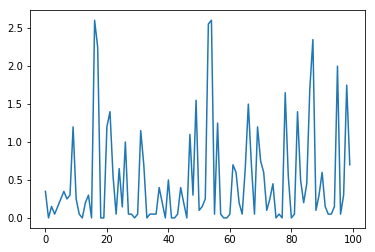

In [32]:
import matplotlib.pyplot as plt
plt.plot(d)
plt.show()

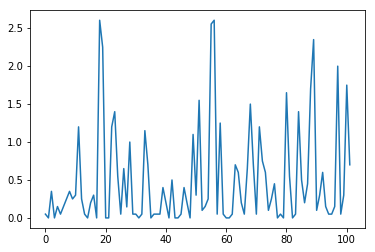

In [33]:
import matplotlib.pyplot as plt
plt.plot(score)
plt.show()

# Saving the agent

In [35]:
#torch.save(maddpg.maddpg_agent,"Marl_policy")

/Users/unnat/miniconda3/envs/drlnd/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
import torch
device = "cpu"
ma_policy = torch.load('Marl_policy')
def get_actions(ma_policy,state):
    obs = torch.from_numpy(state).float().to(device) 
    action = []
    for agent,obs in zip(ma_policy,obs):
        action.append(agent.actor(obs))
    return action

In [12]:
for i_episodes in range(1, 10):
    env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
    states = env_info.vector_observations # get the current state (for each agent)
    #states = torch.Tensor(states)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        #actions=maddpg.act(states, noise =0.00009)
        actions = get_actions(ma_policy,states) 
        actions = [a.detach().numpy() for a in actions]
        actions = np.array(actions).reshape(2,2)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards
        #print(rewards,end="")# get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        #print(states.shape,actions.shape,next_states.shape,"sada")
        #maddpg.step(states,actions,rewards,next_states,dones)
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break


# Watch a Smart Agent

![tennis](https://github.com/unnat5/deep-reinforcement-learning/blob/master/p3_collab-compet/tennis.gif)